In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import json
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
!apt install -y ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
SOURCE_PATH = "drive/MyDrive/GTZAN/Data/genres_original"

JSON_PATH = 'drive/MyDrive/data.json'

sample_rate = 22050

TOTAL_SAMPLES = 29 * sample_rate

NUM_SLICES = 10
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NUM_SLICES)

In [ ]:
def preprocess_data(source_path, json_path):
    genres_dict = {
          'blues': 0,
          'classical': 1,
          'country': 2,
          'disco': 3,
          'hiphop': 4,
          'jazz': 5,
          'metal': 6,
          'pop': 7,
          'reggae': 8,
          'rock': 9,
    }

    mydict = {
        "labels": [],
        "mfcc": []
        }

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(source_path)):
        print(i)
        print(dirpath)
        for file in filenames:
            # exclude corrupted wav file
            if os.path.join(dirpath, file) != SOURCE_PATH + '/jazz/jazz.00054.wav':
                song, sr = librosa.load(os.path.join(dirpath, file), duration=29)
                for s in range(NUM_SLICES):
                    start_sample = SAMPLES_PER_SLICE * s
                    end_sample = start_sample + SAMPLES_PER_SLICE
                    mfcc = librosa.feature.mfcc(y=song[start_sample:end_sample], sr=sr, n_mfcc=13)
                    mfcc = mfcc.T
                    mydict["labels"].append(genres_dict[file.split('.')[0]])
                    mydict["mfcc"].append(mfcc.tolist())
   
    with open(json_path, 'w') as f:
        json.dump(mydict, f)
    f.close()

In [ ]:
def load_data(json_path):

    with open(json_path, 'r') as f:
        data = json.load(f)
    f.close()

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return X, y

In [ ]:
def prepare_datasets(inputs, targets, split_size):
    
    # Splitting sets
    inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs, targets, test_size=split_size)
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs_train, targets_train, test_size=split_size)
    
    # 3D input for CNN
    inputs_train = inputs_train[..., np.newaxis]
    inputs_val = inputs_val[..., np.newaxis]
    inputs_test = inputs_test[..., np.newaxis]
    
    return inputs_train, inputs_val, inputs_test, targets_train, targets_val, targets_test

In [ ]:
def design_model(input_shape):

    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
    ])

    return model

In [ ]:
if __name__ == "__main__":

    # preprocess_data(source_path=SOURCE_PATH, json_path=JSON_PATH)
    
    inputs, targets = load_data(json_path=JSON_PATH)
    
    Xtrain, Xval, Xtest, ytrain, yval, ytest = prepare_datasets(inputs, targets, 0.2)

    input_shape = (Xtrain.shape[1], Xtrain.shape[2], 1)
    model = design_model(input_shape)

    model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics = ['acc']
                     )

    model.summary()

    history = model.fit(Xtrain, ytrain,
                        validation_data=(Xval, yval),
                        epochs=25,
                        batch_size=32
                        )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 123, 11, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 6, 32)        0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 62, 6, 32)        128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 4, 32)         9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 2, 32)        0         
 2D)                                                             
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


200/200 [==============================] - 13s 62ms/step - loss: 1.6144 - acc: 0.4372 - val_loss: 1.8034 - val_acc: 0.3819
Epoch 2/25
200/200 [==============================] - 12s 61ms/step - loss: 1.1633 - acc: 0.5841 - val_loss: 1.3953 - val_acc: 0.5160
Epoch 3/25
200/200 [==============================] - 12s 62ms/step - loss: 1.0156 - acc: 0.6416 - val_loss: 1.2248 - val_acc: 0.5941
Epoch 4/25
200/200 [==============================] - 12s 61ms/step - loss: 0.8892 - acc: 0.6868 - val_loss: 0.9868 - val_acc: 0.6552
Epoch 5/25
200/200 [==============================] - 13s 65ms/step - loss: 0.7969 - acc: 0.7219 - val_loss: 0.8275 - val_acc: 0.7202
Epoch 6/25
200/200 [==============================] - 12s 61ms/step - loss: 0.7232 - acc: 0.7480 - val_loss: 0.8550 - val_acc: 0.7152
Epoch 7/25
200/200 [==============================] - 12s 61ms/step - loss: 0.6735 - acc: 0.7604 - val_loss: 0.8290 - val_acc: 0.7192
Epoch 8/25
200/200 [==============================] - 12s 62ms/step - los

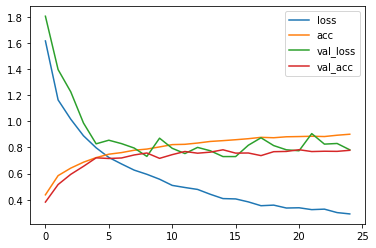

In [ ]:
from matplotlib import pyplot as plt

pd.DataFrame(history.history).plot()
plt.show()

In [ ]:
test_loss,test_acc=model.evaluate(Xtest,ytest,batch_size=128)
print("The test loss is ",test_loss)
print("The best accuracy is: ",test_acc*100)

13/13 [==============================] - 1s 42ms/step - loss: 0.7851 - acc: 0.7624
The test loss is  0.785093367099762
The best accuracy is:  76.23514533042908


In [ ]:
model.save('drive/MyDrive/GTZAN/trained_model')

INFO:tensorflow:Assets written to: drive/MyDrive/GTZAN/trained_model/assets


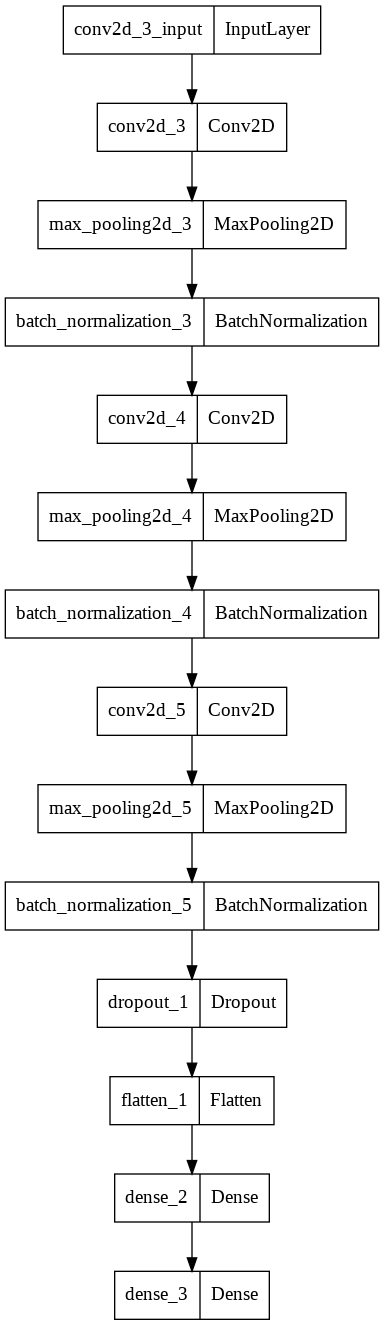

In [26]:
dot_img_file = 'drive/MyDrive/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=False)